# CNA Data
---

In [12]:
import json
import pandas as pd
import glob
import re
import numpy as np 
import matplotlib.pyplot as plt

In [13]:
def get_nested_value(entry, keys, default='Missing_Data'):
    try:
        for key in keys:
            entry = entry[key]
        return entry
    except (KeyError, IndexError):
        return default

row_accumulator = []
for filename in glob.glob('../../Data/NVD/nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            new_row = {
                'CVE': get_nested_value(entry, ['cve', 'id']),
                'Published': get_nested_value(entry, ['cve', 'published']),
                'AttackVector': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackVector']),
                'AttackComplexity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackComplexity']),
                'PrivilegesRequired': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'privilegesRequired']),
                'UserInteraction': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'userInteraction']),
                'Scope': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'scope']),
                'ConfidentialityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'confidentialityImpact']),
                'IntegrityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'integrityImpact']),
                'AvailabilityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'availabilityImpact']),
                'BaseScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseScore'], '0.0'),
                'BaseSeverity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseSeverity']),
                'ExploitabilityScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'exploitabilityScore']),
                'ImpactScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'impactScore']),
                'CWE': get_nested_value(entry, ['cve', 'weaknesses', 0, 'description', 0, 'value']),
                'Description': get_nested_value(entry, ['cve', 'descriptions', 0, 'value'], ''),
                'Assigner': get_nested_value(entry, ['cve', 'sourceIdentifier']),
                'Tag': get_nested_value(entry, ['cve', 'cveTags', 0, 'tags'], np.nan),
                'Status': get_nested_value(entry, ['cve', 'vulnStatus'], '')
            }
            row_accumulator.append(new_row)

nvd = pd.DataFrame(row_accumulator)
nvd = nvd[~nvd.Status.str.contains('Rejected')]
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan);


## CNA Assigner Graphs

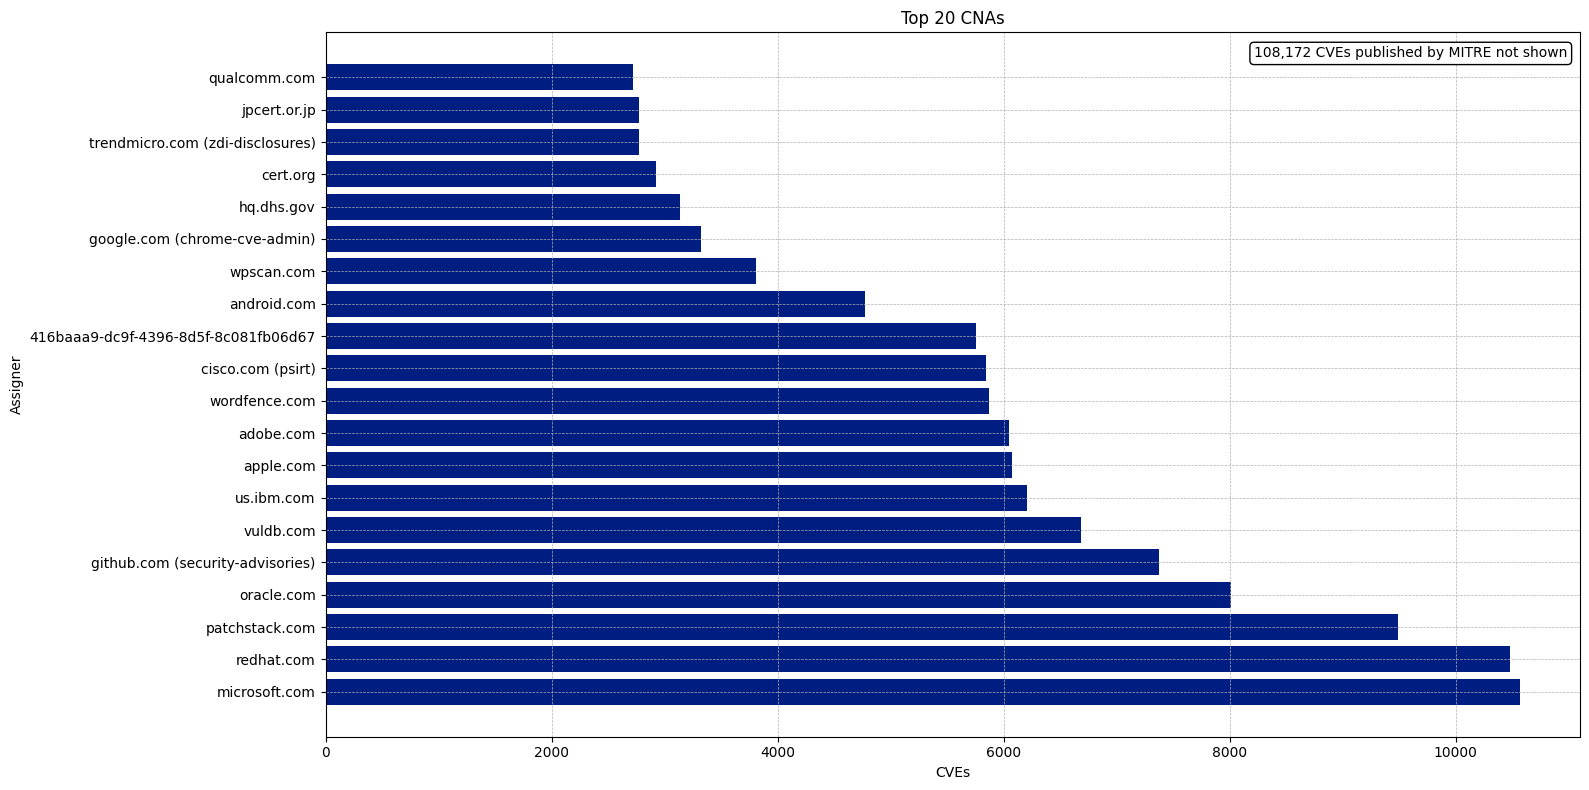

In [14]:
# Replace specific assigner ID with email
nvd['Assigner'] = nvd['Assigner'].replace('416baaa9-dc9f-4396-8d5f-8d5f-8c081fb06d67', 'cve@kernel.org')

# Extract domain names and check for uniqueness
nvd['Domain'] = nvd['Assigner'].apply(lambda x: x.split('@')[-1])
domain_counts = nvd['Domain'].value_counts()

# Modify Assigner column based on domain uniqueness
unique_domains = nvd.groupby('Domain')['Assigner'].nunique()
nvd['Assigner'] = nvd.apply(lambda x: x['Domain'] if unique_domains[x['Domain']] == 1 else f"{x['Domain']} ({x['Assigner'].split('@')[0]})", axis=1)

# Calculate frequency of assigners
nvd_frequency = nvd['Assigner'].value_counts().reset_index()
nvd_frequency.columns = ['Assigner', 'counts']
nvd_frequency = nvd_frequency[nvd_frequency.counts > 100].head(50)

# Calculate the number of CVEs published by mitre.org
mitre_cves = nvd_frequency[nvd_frequency['Assigner'].str.contains('mitre.org')]['counts'].sum()

# Remove mitre.org from the frequency list
nvd_frequency_no_mitre = nvd_frequency[~nvd_frequency.Assigner.str.contains('mitre.org')]
nvd_frequency_no_mitre = nvd_frequency_no_mitre[nvd_frequency_no_mitre.counts > 100].head(20)

# Plot the top 20 CNAs
plt.figure(figsize=(16, 8))
plt.barh("Assigner", "counts", data=nvd_frequency_no_mitre, color="#001d82")
plt.xlabel("CVEs")
plt.ylabel("Assigner")
plt.title("Top 20 CNAs")
plt.grid(True, linestyle='--', linewidth=0.5)

# Add a text box indicating mitre.org has been removed and the number of CVEs they published
textstr = f'{mitre_cves:,} CVEs published by MITRE not shown'
plt.text(0.99, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# Adjust layout and show the chart
plt.tight_layout()
plt.show()

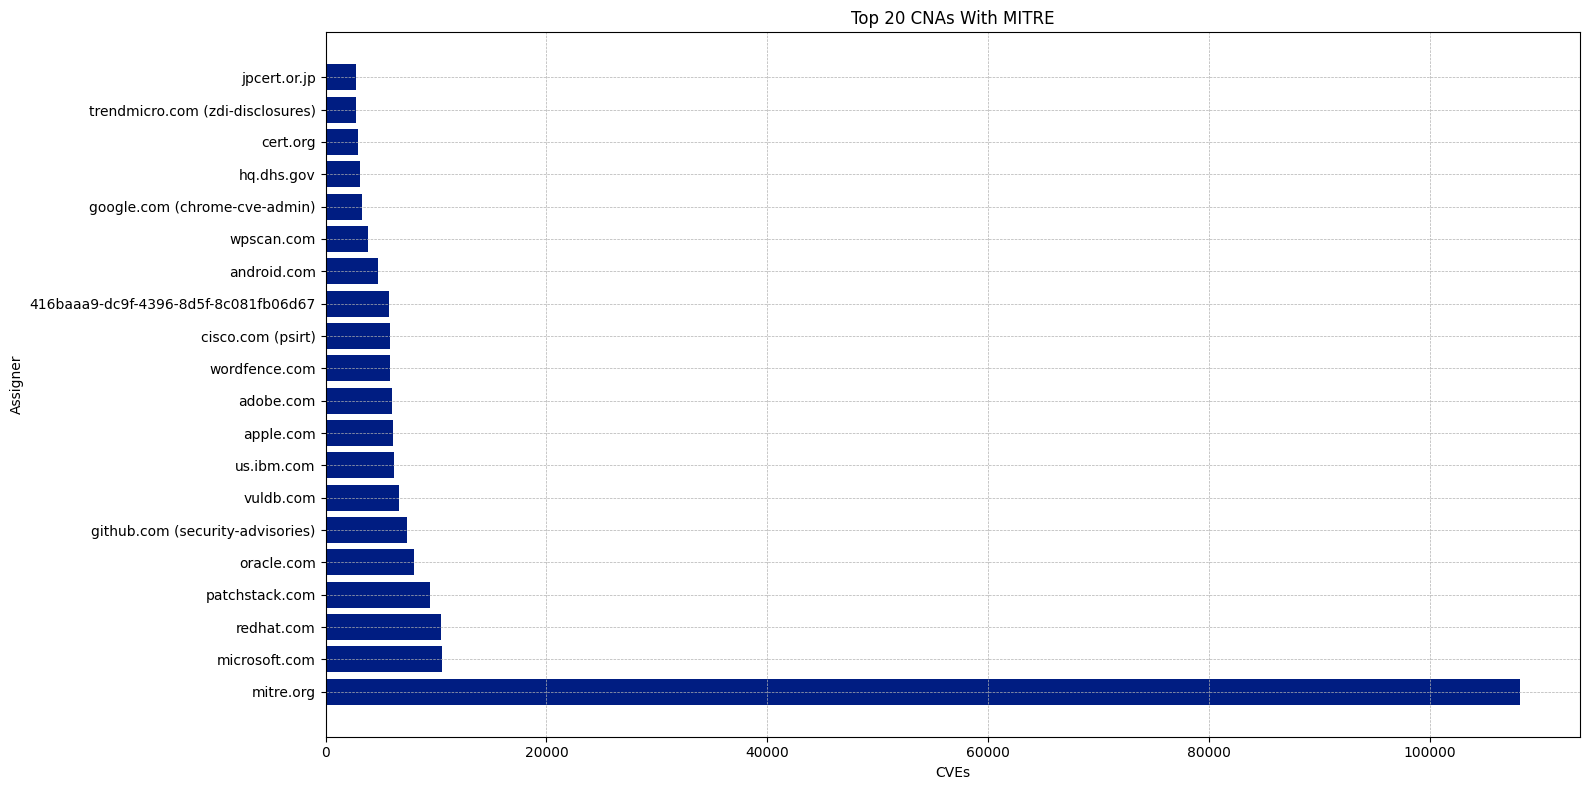

In [15]:
import matplotlib.pyplot as plt

# Replace specific assigner ID with email
nvd['Assigner'] = nvd['Assigner'].replace('416baaa9-dc9f-4396-8d5f-8d5f-8c081fb06d67', 'cve@kernel.org')

# Extract domain names and check for uniqueness
nvd['Domain'] = nvd['Assigner'].apply(lambda x: x.split('@')[-1])
domain_counts = nvd['Domain'].value_counts()

# Modify Assigner column based on domain uniqueness
unique_domains = nvd.groupby('Domain')['Assigner'].nunique()
nvd['Assigner'] = nvd.apply(lambda x: x['Domain'] if unique_domains[x['Domain']] == 1 else f"{x['Domain']} ({x['Assigner'].split('@')[0]})", axis=1)

# Calculate frequency of assigners
nvd_frequency = nvd['Assigner'].value_counts().reset_index()
nvd_frequency.columns = ['Assigner', 'counts']
nvd_frequency = nvd_frequency[nvd_frequency.counts > 100].head(50)

# Plot the top 20 CNAs including MITRE
plt.figure(figsize=(16, 8))
plt.barh("Assigner", "counts", data=nvd_frequency.head(20), color="#001d82")
plt.xlabel("CVEs")
plt.ylabel("Assigner")
plt.title("Top 20 CNAs With MITRE")
plt.grid(True, linestyle='--', linewidth=0.5)

# Adjust layout and show the chart
plt.tight_layout()
plt.show()

## Top CVE Assigners

In [16]:
# Replace specific assigner ID with email
nvd['Assigner'] = nvd['Assigner'].replace('416baaa9-dc9f-4396-8d5f-8d5f-8c081fb06d67', 'cve@kernel.org')

# Extract domain names and check for uniqueness
nvd['Domain'] = nvd['Assigner'].apply(lambda x: x.split('@')[-1])
domain_counts = nvd['Domain'].value_counts()

# Modify Assigner column based on domain uniqueness
unique_domains = nvd.groupby('Domain')['Assigner'].nunique()
nvd['Assigner'] = nvd.apply(lambda x: x['Domain'] if unique_domains[x['Domain']] == 1 else f"{x['Domain']} ({x['Assigner'].split('@')[0]})", axis=1)

# Calculate frequency of assigners
nvd_frequency = nvd['Assigner'].value_counts().reset_index()
nvd_frequency.columns = ['Assigner', 'counts']

# Save nvd_frequency to a CSV file
nvd_frequency.to_csv('CNACounts.csv', index=False)

nvd_frequency

,Assigner,counts
0,mitre.org,108172
1,microsoft.com,10570
2,redhat.com,10480
3,patchstack.com,9490
4,oracle.com,8012
...,...,...
370,88ee5874-cf24-4952-aea0-31affedb7ff2,1
371,1d66c9f9-fff2-411a-aa19-ca6312fa25e9,1
372,9947ef80-c5d5-474a-bbab-97341a59000e,1
373,list.alibaba-inc.com,1
